In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

- Design a query to retrieve the last 12 months of precipitation data and plot the results
- Calculate the date 1 year ago from the last data point in the database
- Perform a query to retrieve the data and precipitation scores
- Save the query results as a Pandas DataFrame and set the index to the date column
- Sort the dataframe by date
- Use Pandas Plotting with Matplotlib to plot the data

In [11]:
# Last data point in the db
latest_date = session.query(Measurement.prcp, Measurement.date)\
.order_by(Measurement.date.desc())

session.query(Measurement.date)\
.order_by(Measurement.date.desc()).first()

('2017-08-23')

In [12]:
# Set start date and end date for vacation - use a date range of 3-15 days
vaca_start_date = dt.date(2017, 5, 20)
vaca_end_date = dt.date(2017, 5, 30)

In [13]:
# Calculate the date 1 year ago from the last data point in the database
prep_lst = []
prep_dat = latest_date.filter(Measurement.date >= '2016-08-23' )
for i in prep_dat:
    prep_lst.append(i)

In [14]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort by date
prep_df = pd.DataFrame(prep_lst, columns=['Precipitation', 'Date']).sort_values("Date",ascending=True).dropna()
prep_df = prep_df.set_index('Date')
prep_df.head()

,Precipitation
Date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,0.02


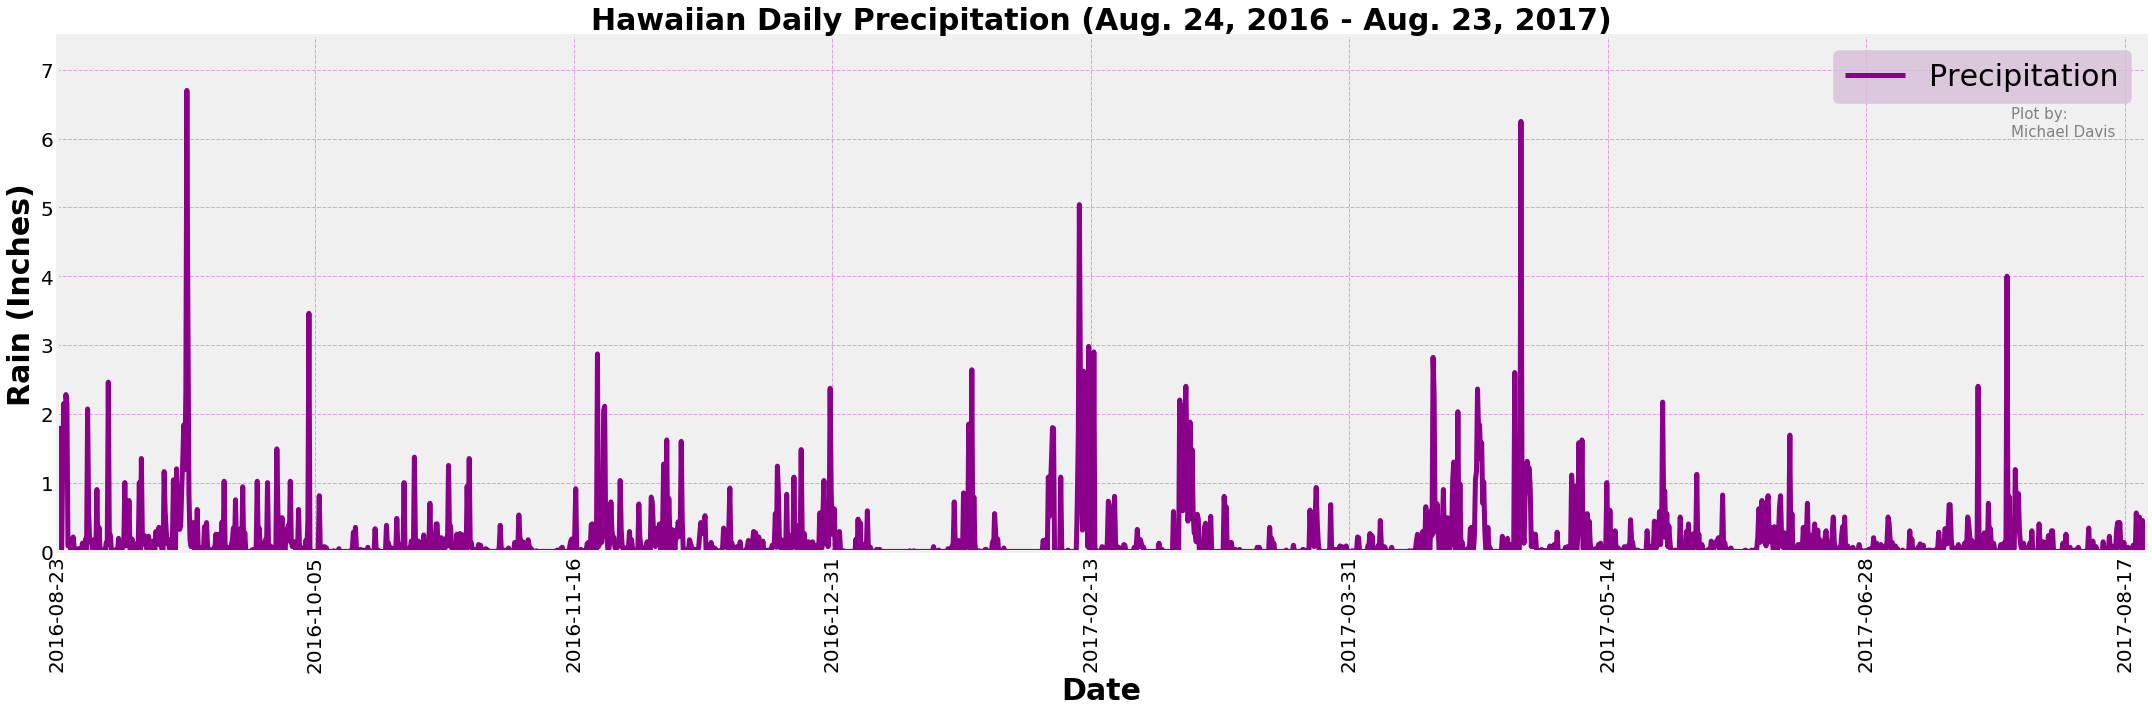

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
prep_df.plot(y = 'Precipitation', linewidth=5, figsize=(30,10), fontsize=20, color="darkmagenta")
plt.title("Hawaiian Daily Precipitation (Aug. 24, 2016 - Aug. 23, 2017)", fontsize=30, weight="bold")
plt.legend(["Precipitation"], loc="best", fontsize=30, facecolor="thistle")
plt.xlabel("Date", fontsize=30, weight="bold")
plt.ylabel("Rain (Inches)", fontsize=30, weight="bold")
plt.ylim(0, 7.5)
plt.grid(color='plum', linestyle='--', linewidth=1)
plt.xticks(rotation=90)
plt.annotate('Plot by:\nMichael Davis', xy=(1890, 6.04), fontsize=15, color="gray")
plt.tight_layout()
plt.savefig("Hawaii_Precep_Aug_2016_to_2017.png")
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prep_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Station.station).count()
print(f"Number of stations: {number_stations}")

Number of stations: 9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in station_count:
    print(f"Station: {result[0]}\tCount: {result[1]}")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
USC281 = session.query(Measurement.station
                       ,func.min(Measurement.tobs).label('lowest temp')
                       ,func.max(Measurement.tobs).label('highest temp')
                       ,func.avg(Measurement.tobs).label('average temp'))\
                        .filter(Measurement.station == 'USC00519281').statement

USC281_data = pd.read_sql_query(USC281, session.bind)
USC281_data

,station,lowest temp,highest temp,average temp
0,USC00519281,54.0,85.0,71.663781


In [20]:
# Choose the station with the highest number of temperature observations.
most_active_station = session.query(Measurement.station).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()

print(f"The most active weather station is: {most_active_station.station}")

The most active weather station is: USC00519281


In [21]:
tobs_query = session.query(Measurement.tobs, Measurement.station).\
filter(Measurement.date >='2016-08-23', Measurement.date <='2017-08-23').\
filter(Measurement.station==most_active_station.station).\
order_by(Measurement.date).statement 

tobs_df = pd.read_sql(tobs_query, engine).dropna()
tobs_df.head(5)

,tobs,station
0,77.0,USC00519281
1,77.0,USC00519281
2,80.0,USC00519281
3,80.0,USC00519281
4,75.0,USC00519281


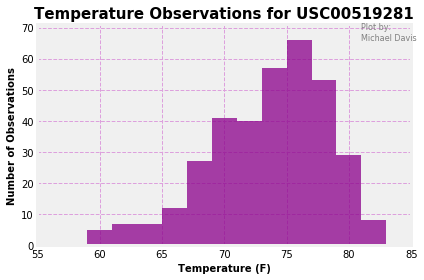

In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
x = tobs_df['tobs']

plt.hist(x, bins=12, linewidth=15, alpha=0.75, color="darkmagenta")
plt.title(f"Temperature Observations for {most_active_station.station}", fontsize=15, weight="bold")
plt.xlabel("Temperature (F)", fontsize=10, weight="bold")
plt.ylabel("Number of Observations", fontsize=10, weight="bold")
plt.xlim(55,85)
plt.ylim(0,71)
plt.grid(color='plum', linestyle='--', linewidth=1)
plt.annotate('Plot by:\nMichael Davis', xy=(81, 66), fontsize=8, color="gray")
plt.tight_layout()
plt.savefig("Temperature_Observations_for_Top_Site.png")
plt.show()

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps(vaca_start_date, vaca_end_date))

[(69.0, 75.23809523809524, 87.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
TMIN = calc_temps(vaca_start_date, vaca_end_date)[0][0]
TAVG = calc_temps(vaca_start_date, vaca_end_date)[0][1]
TMAX = calc_temps(vaca_start_date, vaca_end_date)[0][2]

print(f'Vacation Minimum Temperature: {"{0:.2f}".format(TMIN)}')
print(f'Vacation Average Temperature: {"{0:.2f}".format(TAVG)}')
print(f'Vacation Maximum Temperature: {"{0:.2f}".format(TMAX)}')

Vacation Minimum Temperature: 69.00
Vacation Average Temperature: 75.24
Vacation Maximum Temperature: 87.00


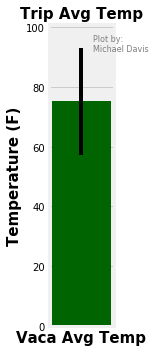

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = TMAX - TMIN

plt.figure(figsize=(2,5))
plt.bar(1, TAVG, yerr=yerr, width=1, color="darkgreen")
plt.title("Trip Avg Temp", fontsize=15, weight="bold")
plt.ylim(0,101)
plt.xlabel("Vaca Avg Temp", fontsize=15, weight="bold")
plt.ylabel("Temperature (F)", fontsize=15, weight="bold")
plt.xticks([])
plt.annotate('Plot by:\nMichael Davis', xy=(1.2, 92), fontsize=8, color="gray")
plt.tight_layout()
plt.savefig("Trip_Avg_Temp.png")
plt.show()

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_rainfall = session.query(Measurement.station, func.sum(Measurement.prcp))\
.group_by(Measurement.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()

station_info = session.query(Station.station, Station.name, Station.latitude, Station.longitude).all()

rainfall_df = pd.DataFrame(station_rainfall, columns = ['Station', 'Rainfall sum'])
station_df = pd.DataFrame(station_info, columns = ["Station", 'Station Name', "latitude", "longitude"])

combined_df = pd.merge(rainfall_df, station_df, on = "Station", how = 'inner')
combined_df

,Station,Rainfall sum,Station Name,latitude,longitude
0,USC00516128,1068.09,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250
1,USC00519281,588.64,"WAIHEE 837.5, HI US",21.45167,-157.84889
2,USC00513117,382.62,"KANEOHE 838.1, HI US",21.42340,-157.80150
3,USC00519523,295.68,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139
4,USC00514830,234.49,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740
5,USC00519397,131.62,"WAIKIKI 717.2, HI US",21.27160,-157.81680
6,USC00511918,92.68,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920
7,USC00518838,70.87,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110
8,USC00517948,43.44,"PEARL CITY, HI US",21.39340,-157.97510


## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
vaca_start_date = dt.date(2017, 5, 20)
vaca_end_date = dt.date(2017, 5, 30)

In [29]:
# Use the start and end date to create a range of dates
vacation_dates = pd.date_range(vaca_start_date, vaca_end_date, freq= '1D')
vacation_dates

DatetimeIndex(['2017-05-20', '2017-05-21', '2017-05-22', '2017-05-23',
               '2017-05-24', '2017-05-25', '2017-05-26', '2017-05-27',
               '2017-05-28', '2017-05-29', '2017-05-30'],
              dtype='datetime64[ns]', freq='D')

In [30]:
# Stip off the year and save a list of %m-%d strings
vacation_dates2 = vacation_dates.strftime("%m-%d")
vacation_dates2

Index(['05-20', '05-21', '05-22', '05-23', '05-24', '05-25', '05-26', '05-27',
       '05-28', '05-29', '05-30'],
      dtype='object')

In [35]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals =[]
for day in vacation_dates2:
         normals.append(*daily_normals(day)) 

print(f"Daily Normals: {normals}")

Daily Normals: [(68.0, 73.89655172413794, 79.0), (64.0, 72.96428571428571, 80.0), (64.0, 74.45614035087719, 80.0), (68.0, 74.94827586206897, 87.0), (67.0, 73.94827586206897, 79.0), (68.0, 74.27586206896552, 79.0), (65.0, 74.03636363636363, 82.0), (65.0, 74.49090909090908, 80.0), (67.0, 74.27777777777777, 82.0), (64.0, 74.19607843137256, 80.0), (69.0, 74.33333333333333, 81.0)]


In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
rainfall_df = pd.DataFrame(normals,columns=['TMIN','TAVG','TMAX'])
rainfall_df['Date'] = vacation_dates2
df = rainfall_df.reindex(columns=['Date','TMIN','TAVG','TMAX'])
df

,Date,TMIN,TAVG,TMAX
0,05-20,68.0,73.896552,79.0
1,05-21,64.0,72.964286,80.0
2,05-22,64.0,74.456140,80.0
3,05-23,68.0,74.948276,87.0
4,05-24,67.0,73.948276,79.0
5,05-25,68.0,74.275862,79.0
6,05-26,65.0,74.036364,82.0
7,05-27,65.0,74.490909,80.0
8,05-28,67.0,74.277778,82.0
9,05-29,64.0,74.196078,80.0


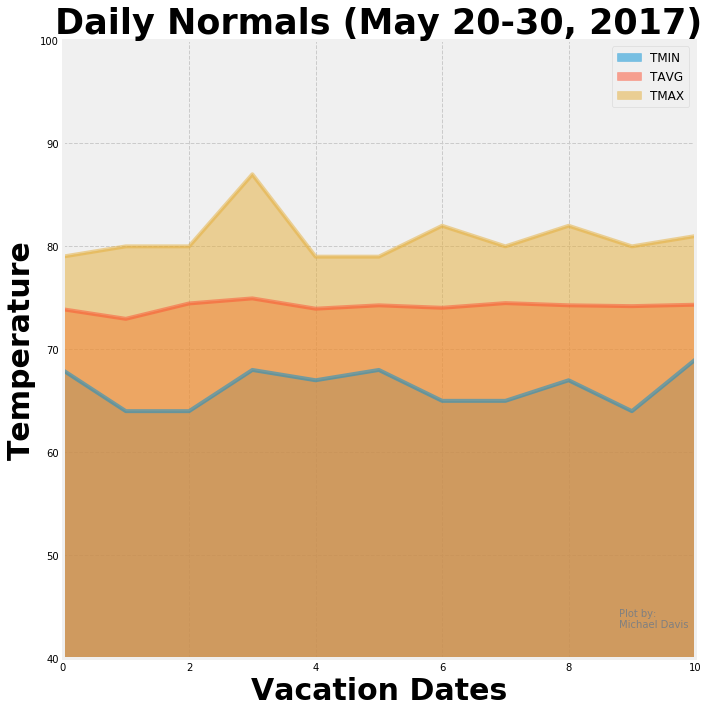

In [37]:
# Plot the daily normals as an area plot with `stacked=False`

ax = df.plot.area(stacked=False)
plt.title("Daily Normals (May 20-30, 2017)", fontsize=35, weight="bold")
plt.legend(loc='upper left', fontsize=15, facecolor="thistle")
plt.xlabel('Vacation Dates', fontsize=30, weight="bold")
plt.ylabel('Temperature', fontsize=30, weight="bold")
plt.ylim(40,100)
plt.grid(True, linestyle='--', linewidth=1)
plt.legend(loc="best", fontsize="large", fancybox=True)
plt.xticks(rotation=0)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.annotate('Plot by:\nMichael Davis', xy=(8.8, 43), fontsize=10, color="gray")
plt.tight_layout()
plt.savefig("Daily_Normals_May_20-30_2017.png")
plt.show()